In [2]:
import os
os.chdir("..")

In [3]:
import os
import time
#basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

#word modeling
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA 
from sklearn.decomposition import FactorAnalysis 
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from gensim.parsing.preprocessing import remove_stopwords
import nltk

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings('ignore',message="Precision")

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation


In [2]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [4]:
n_features = 2000
n_top_words = 20

# load data


In [5]:
train_docs = pd.read_csv('extracted/dataframes/steam_australia_norm_w2v.csv', 
                         names=["id", "funny", "helpful", "recommend",
                               "polarity", "positive", "subjectivity", "review"],
                        header=None).reset_index(drop=True)[1:]
recommend_indices = [i for i, x in enumerate(np.array(train_docs["recommend"])) if type(x) == str]
train_docs

,id,funny,helpful,recommend,polarity,positive,subjectivity,review
1,76561197970982479,NaN,No ratings yet,1,0.17444444444444446,True,0.3796031746031746,simple yet with great replaceability in my opi...
2,76561197970982479,NaN,No ratings yet,1,0.3375,True,0.55,its unique and worth a
3,76561197970982479,NaN,No ratings yet,1,0.04999999999999999,False,0.4125,great atmosphere the gunplay can be a bit chun...
4,js41637,NaN,15 of 20 people (75%) found this review helpful,1,0.11458333333333336,True,0.6604166666666667,i know what you think when you see this title ...
5,js41637,NaN,0 of 1 people (0%) found this review helpful,1,-0.03611111111111112,False,0.3780045351473924,for a simple its actually not all that simple ...
...,...,...,...,...,...,...,...,...
59301,76561198312638244,NaN,No ratings yet,1,0.2333333333333333,True,0.13333333333333333,a Must_Have classic from steam definitely wort...
59302,76561198312638244,NaN,No ratings yet,1,0.14250000000000004,True,0.4425,this game is a perfect remake of the original ...
59303,LydiaMorley,1 person found this review funny,1 of 2 people (50%) found this review helpful,1,0.08750000000000001,False,0.3833333333333333,had so much fun placing this and collecting re...
59304,LydiaMorley,NaN,No ratings yet,1,1.0,True,1.0,d


In [6]:
data_samples = train_docs['review']
t0 = time()
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf  = tfidf_vectorizer.fit_transform(data_samples.astype('U'))
print("done in %0.3fs." % (time() - t0))


done in 1.880s.


In [34]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples.astype('U'))


In [35]:
true_y = np.array(np.array(train_docs["recommend"])[recommend_indices], dtype=int)
np.unique(true_y)
data = tf.toarray()[recommend_indices]

In [36]:
flda = LinearDiscriminantAnalysis(n_components=1, tol=0.01)
t0 = time()
flda.fit(data, true_y)
print("done in %0.3fs." % (time() - t0))

done in 46.140s.


# Precision

In [37]:
predict_y = flda.predict(tf.toarray()[recommend_indices])
arr = np.concatenate((predict_y.reshape([-1, 1]), true_y.reshape([-1, 1])), 1)

total = len(arr)
corrects = [i for i, x in enumerate(arr) if x[0] == x[1]]
print("Model accuracy:", len(corrects), "/", total, len(corrects)/total)
print("Predict only Recommended accuracy:", np.sum(true_y), "/", total, np.sum(true_y)/total)

Model accuracy: 53867 / 59305 0.90830452744288
Predict only Recommended accuracy: 52473 / 59305 0.8847989208329821


In [38]:
def heatconmat(y_true, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r')
    plt.show()
    print(classification_report(y_true,y_pred))

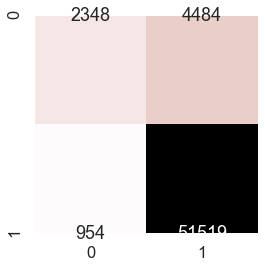

              precision    recall  f1-score   support

           0       0.71      0.34      0.46      6832
           1       0.92      0.98      0.95     52473

    accuracy                           0.91     59305
   macro avg       0.82      0.66      0.71     59305
weighted avg       0.90      0.91      0.89     59305



In [39]:
heatconmat(true_y, predict_y)

Predicting too many recommendations because of the bias in the data (Need to rectify)

In [13]:
z = flda.transform(tf.toarray()[recommend_indices])
df_y = pd.DataFrame(np.concatenate((arr, z.reshape(-1, 1)),1), columns=["predictions", "true", "z"])
df_y

,predictions,true,z
0,1.0,1.0,-0.153709
1,1.0,1.0,0.145833
2,1.0,1.0,1.036184
3,1.0,1.0,-1.095684
4,1.0,1.0,1.331724
...,...,...,...
59300,1.0,1.0,0.367005
59301,1.0,1.0,1.159335
59302,1.0,1.0,0.561026
59303,1.0,1.0,-0.035698


Recommendation distribution

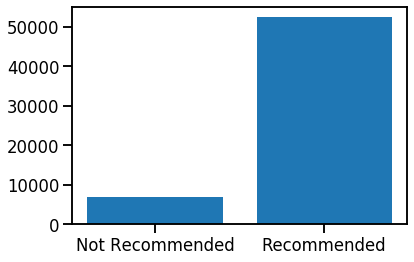

In [14]:
fig, ax = plt.subplots()
ax.bar([0,1], [len(df_y["true"]) - np.sum(df_y["true"]), np.sum(df_y["true"])])
ax.set_xticks([0, 1])
ax.set_xticklabels(["Not Recommended", "Recommended"])
ax.grid(False)

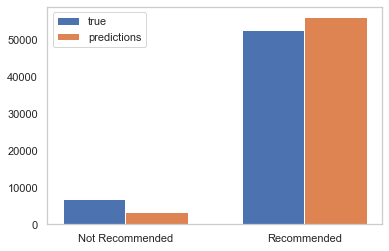

In [15]:
sns.set(style="whitegrid")
n_true_recommend = sum(df_y["true"])
n_true_preds = sum(df_y["predictions"])
n_false_recommend = len(df_y["true"]) - n_true_recommend
n_false_preds = len(df_y["predictions"]) - n_true_preds
x = np.array([0, 1])

width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [n_false_recommend, n_true_recommend], width, label='true')
rects2 = ax.bar(x + width/2, [n_false_preds, n_true_preds], width, label='predictions')
ax.set_xticks(x)
ax.set_xticklabels(["Not Recommended", "Recommended"])
ax.legend()
ax.grid(False)

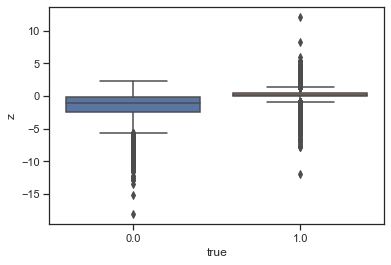

In [16]:
sns.set(style="ticks", color_codes=True)
sns.boxplot(x="true", y="z", data=df_y);

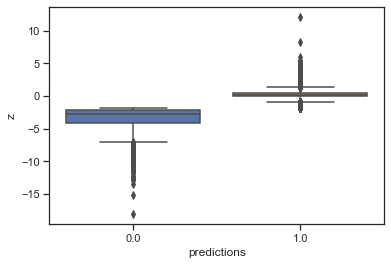

In [17]:
sns.set(style="ticks", color_codes=True)
sns.boxplot(x="predictions", y="z", data=df_y);

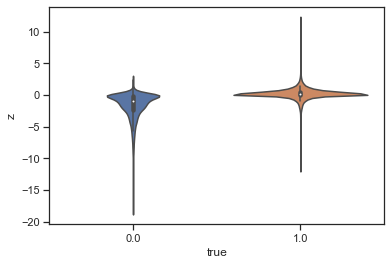

In [18]:
sns.set(style="ticks", color_codes=True)
sns.violinplot(x="true", y="z", data=df_y);

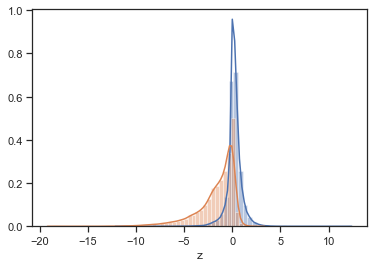

In [19]:
sns.set(style="ticks", color_codes=True)
sns.distplot(df_y["z"][df_y["true"] == 1], hist=True, label="Recommended")
sns.distplot(df_y["z"][df_y["true"] == 0], hist=True, label="Not Recommended")

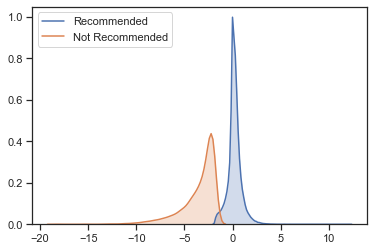

In [20]:
sns.set(style="ticks", color_codes=True)
sns.kdeplot(df_y["z"][df_y["predictions"] == 1], shade=True, label="Recommended")
sns.kdeplot(df_y["z"][df_y["predictions"] == 0], shade=True, label="Not Recommended")

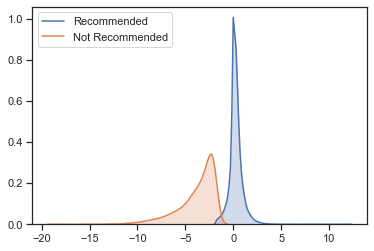

In [21]:
y = np.array(df_y["predictions"])
arr = np.concatenate((y.reshape([-1, 1]), true_y.reshape([-1, 1])), 1)
corrects = [i for i, x in enumerate(arr) if x[0] == x[1]]
corrects_pos = [i for i, x in enumerate(arr) if x[0] == x[1] and x[0] == 1]
corrects_neg = [i for i, x in enumerate(arr) if x[0] == x[1] and x[0] == 0]
sns.set(style="ticks", color_codes=True)
sns.kdeplot(df_y["z"][corrects_pos], shade=True, label="Recommended")
sns.kdeplot(df_y["z"][corrects_neg], shade=True, label="Not Recommended")

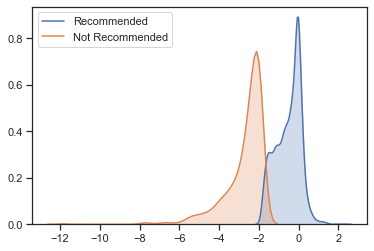

In [22]:
incorrects = [i for i, x in enumerate(arr) if x[0] == x[1]]
incorrects_pos = [i for i, x in enumerate(arr) if x[0] != x[1] and x[0] == 1]
incorrects_neg = [i for i, x in enumerate(arr) if x[0] != x[1] and x[0] == 0]
sns.set(style="ticks", color_codes=True)
sns.kdeplot(df_y["z"][incorrects_pos], shade=True, label="Recommended")
sns.kdeplot(df_y["z"][incorrects_neg], shade=True, label="Not Recommended")

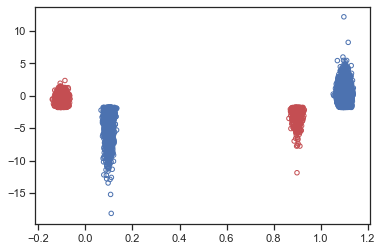

In [23]:
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

df_y["true"] = np.array([float(x) for x in df_y["true"]])
df_y["true"] = rand_jitter(np.array(df_y["true"]))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(df_y["true"][corrects_pos]+0.1, df_y["z"][corrects_pos], marker="o", s=20, facecolors='none', edgecolors='b')
ax.scatter(df_y["true"][corrects_neg]+0.1, df_y["z"][corrects_neg], marker="o", s=20, facecolors='none', edgecolors='b')
ax.scatter(df_y["true"][incorrects_pos]-0.1, df_y["z"][incorrects_pos], marker="o", s=20, facecolors='none', edgecolors='r')
ax.scatter(df_y["true"][incorrects_neg]-0.1, df_y["z"][incorrects_neg], marker="o", s=20, facecolors='none', edgecolors='r')


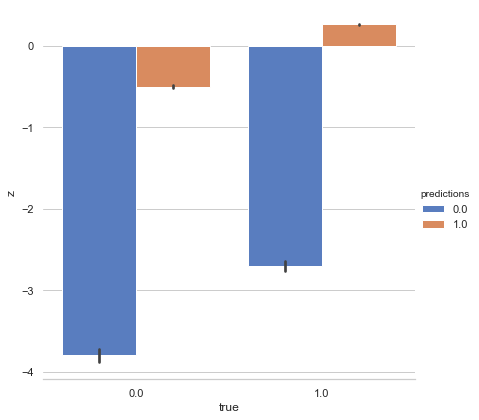

In [24]:
import seaborn as sns
df_y = pd.DataFrame(np.concatenate((arr, z.reshape(-1, 1)),1), columns=["predictions", "true", "z"])
sns.set(style="whitegrid")
g = sns.catplot(x="true", y="z", hue="predictions", data=df_y,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("z")

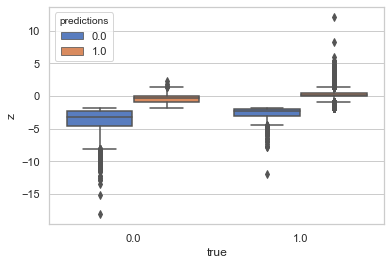

In [25]:
import seaborn as sns
df_y = pd.DataFrame(np.concatenate((arr, z.reshape(-1, 1)),1), columns=["predictions", "true", "z"])
# sns.set(style="whitegrid")
g = sns.boxplot(x="true", y="z", hue="predictions", data=df_y, palette="muted")

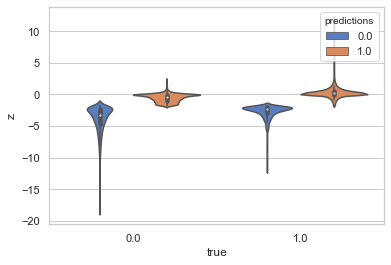

In [26]:
g = sns.violinplot(x="true", y="z", hue="predictions", data=df_y, palette="muted")

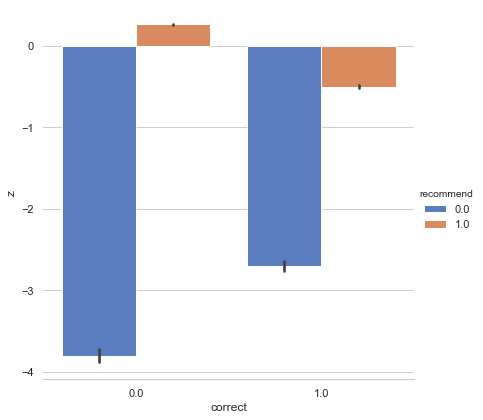

In [27]:
import seaborn as sns
arr = np.concatenate((y.reshape([-1, 1]), true_y.reshape([-1, 1])), 1)
corrects = np.array([0 if x[0] == x[1] else 1 for i, x in enumerate(arr)])
recommends = np.array([0 if x[0] == 0 else 1 for i, x in enumerate(arr)])

df_y2 = pd.DataFrame(np.concatenate((corrects.reshape(-1, 1), 
                                    recommends.reshape(-1, 1), 
                                    z.reshape(-1, 1)),1), 
                    columns=["correct", "recommend", "z"])

sns.set(style="whitegrid")
g = sns.catplot(x="correct", y="z", hue="recommend", data=df_y2,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("z")

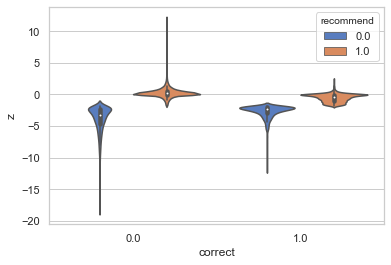

In [28]:
g = sns.violinplot(x="correct", y="z", hue="recommend", data=df_y2, palette="muted")

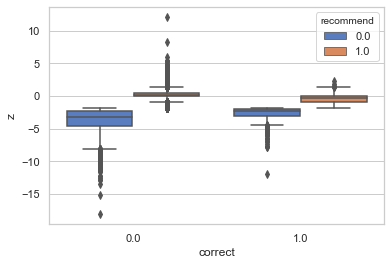

In [29]:
g = sns.boxplot(x="correct", y="z", hue="recommend", data=df_y2, palette="muted")

In [59]:
tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names()).reshape([-1, 1])
coefs = flda.coef_.reshape([-1, 1])
coefs = pd.DataFrame(np.concatenate((coefs, tfidf_feature_names), 1), columns=["coef", "feature_name"])
coefs

,coef,feature_name
0,0.2767168730662199,1080
1,0.3252221179022229,14
2,-0.899505519037352,16
3,0.6673713522651742,1st
4,-0.04836207723412471,2d
...,...,...
1995,0.17895489248880342,your_own
1996,0.23442582454305722,youre
1997,0.021631601178618988,youve
1998,-0.10702347747920321,zombie


In [60]:
coefs["coef"] = np.array(coefs["coef"], dtype=np.float32)
coefs.sort_values(by=['coef'])[:20]


,coef,feature_name
1846,-4.164489,uninstalled
1458,-3.774274,refund
1704,-3.684061,sucks
1968,-3.619872,worst
871,-3.484409,horrible
471,-3.414755,disappointing
1811,-3.399493,trash
208,-3.206663,bother
1855,-3.139005,unplayable
1356,-2.985664,poorly


In [62]:
coefs.sort_values(by=['coef'], ascending=False)[:20]


,coef,feature_name
498,1.593756,drill
319,1.551919,common
263,1.546208,cent
327,1.495556,complaining
801,1.486227,hao
1591,1.484589,shower
1734,1.464284,target
1739,1.298526,teammates
200,1.295208,bonus
1778,1.283279,throw


In [32]:
means = flda.means_
means_df = pd.DataFrame(np.concatenate((means.reshape([n_features, -1]), tfidf_feature_names), 1),
                        columns=["bad_reference", "good_reference", "feature_name"])

means_df["bad_reference"] = np.array(means_df["bad_reference"], dtype=np.float32)
means_df = means_df.sort_values(by=['bad_reference'], ascending=False)
means_df[:n_top_words]

,bad_reference,good_reference,feature_name
519,0.219701,0.00702576112412178,easy
68,0.203308,0.001756440281030445,alpha
241,0.196575,0.000585480093676815,buying
1353,0.170488,0.0015055361805118824,police
1519,0.158367,0.004916814361671717,russian
0,0.133636,0.003951990632318501,1080
891,0.128952,0.032201405152224825,hype
1000,0.126446,0.002763325900939531,lacking
120,0.121487,0.021662763466042154,attempt
359,0.111534,0.002488290398126464,cossas


In [65]:
means_df["good_reference"] = np.array(means_df["good_reference"], dtype=np.float32)
means_df = means_df.sort_values(by=['good_reference'], ascending=False)
means_df[:n_top_words]

,bad_reference,good_reference,feature_name
536,0.001756,1.370214,conclusion
2036,0.000960,0.966585,pretty
2064,0.006238,0.177630,provide
2032,0.003664,0.171523,prepared
564,0.007376,0.149982,core
377,0.012645,0.128205,buttons
532,0.005971,0.114155,computer
539,0.005620,0.111697,connect
1638,0.005322,0.109798,medium
857,0.003512,0.107130,enjoyed


In [81]:
print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n")

# RESAMPLING: SMOTE

In [40]:
from imblearn.over_sampling import SVMSMOTE, SMOTE, BorderlineSMOTE, RandomOverSampler, KMeansSMOTE, ADASYN

# sm = SVMSMOTE(random_state=42, n_jobs=-1, svm_estimator=SVC(kernel='linear'))
sm = SMOTE(random_state=42, n_jobs=-1)

X_res, y_res = sm.fit_resample(data, true_y)


In [41]:
flda_smote = LinearDiscriminantAnalysis(n_components=1, tol=0.1)
t0 = time()
flda_smote.fit(X_res, y_res)
print("done in %0.3fs." % (time() - t0))

done in 97.000s.


In [42]:
predict_y = flda_smote.predict(X_res)
arr = np.concatenate((predict_y.reshape([-1, 1]), y_res.reshape([-1, 1])), 1)

total = len(arr)
corrects = [i for i, x in enumerate(arr) if x[0] == x[1]]
print("Model accuracy:", len(corrects), "/", total, len(corrects)/total)
print("Predict only Recommended accuracy:", np.sum(y_res), "/", total, np.sum(y_res)/total)

Model accuracy: 84388 / 104946 0.804108779753397
Predict only Recommended accuracy: 52473 / 104946 0.5


In [43]:
z = flda_smote.transform(X_res)
df_y = pd.DataFrame(np.concatenate((arr, z.reshape(-1, 1)),1), columns=["predictions", "true", "z"])
df_y

,predictions,true,z
0,1.0,1.0,1.345409
1,1.0,1.0,0.148366
2,1.0,1.0,1.302738
3,1.0,1.0,0.419430
4,1.0,1.0,2.213487
...,...,...,...
104941,0.0,0.0,-0.617351
104942,0.0,0.0,-2.238996
104943,0.0,0.0,-1.044731
104944,0.0,0.0,-1.295167


In [49]:
tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names()).reshape([-1, 1])
coefs = flda_smote.coef_.reshape([-1, 1])
coefs = pd.DataFrame(np.concatenate((coefs, tfidf_feature_names), 1), columns=["coef", "feature_name"])

In [50]:
coefs.sort_values(by=['coef'], ascending=False)

,coef,feature_name
1872,6.2953442670167e-05,uses
783,2.4379205981647547,gud
764,1.7664897039714893,gr
1785,1.6736914430431478,timo
710,1.671005924759493,funniest
...,...,...
461,-0.002205269707096947,difference
1999,-0.00187735161822644,zombies
1195,-0.0018055140951953198,multilayer
813,-0.0015337126497316639,hate


In [51]:
coefs["coef"] = np.array(coefs["coef"], dtype=np.float)

In [52]:
coefs.sort_values(by=['coef'], ascending=False)[:20]

,coef,feature_name
783,2.437921,gud
764,1.766490,gr
1785,1.673691,timo
710,1.671006,funniest
852,1.663489,higra
38,1.645060,addicting
145,1.615116,bang
898,1.576700,ign
39,1.562537,addictive
286,1.555831,childhood


In [53]:
coefs.sort_values(by=['coef'], ascending=True)[:20]

,coef,feature_name
1846,-1.797779,uninstalled
1704,-1.501187,sucks
1811,-1.365430,trash
1968,-1.362284,worst
1458,-1.323910,refund
248,-1.300328,cancer
1754,-1.298848,terrible
205,-1.285051,boring
436,-1.250546,depending
1658,-1.223268,spot


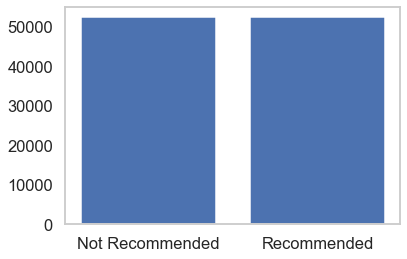

In [54]:
fig, ax = plt.subplots()
ax.bar([0,1], [len(df_y["true"]) - np.sum(df_y["true"]), np.sum(df_y["true"])])
ax.set_xticks([0, 1])
ax.set_xticklabels(["Not Recommended", "Recommended"])
ax.grid(False)

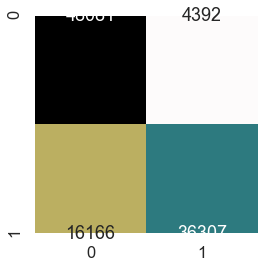

              precision    recall  f1-score   support

         0.0       0.75      0.92      0.82     52473
         1.0       0.89      0.69      0.78     52473

    accuracy                           0.80    104946
   macro avg       0.82      0.80      0.80    104946
weighted avg       0.82      0.80      0.80    104946



In [55]:
true_y2 = np.array(df_y["true"])
heatconmat(true_y2, predict_y)

In [56]:
means = flda_smote.means_
means_df = pd.DataFrame(np.concatenate((means.reshape([n_features, -1]), tfidf_feature_names), 1),
                        columns=["bad_reference", "good_reference", "feature_name"])

means_df["bad_reference"] = np.array(means_df["bad_reference"], dtype=np.float32)
means_df = means_df.sort_values(by=['bad_reference'], ascending=False)
means_df[:n_top_words]

,bad_reference,good_reference,feature_name
1358,0.953023,0.0014864787605054029,por
358,0.950222,0.00019057420006479524,corner
1380,0.175157,0.0025346368608617767,pro
1521,0.158367,0.004916814361671717,rust
1386,0.158272,0.005240790501781869,progress
1484,0.127837,0.010271949383492462,result
1000,0.126446,0.002763325900939531,lacking
484,0.121758,0.0035065652811922324,dont
242,0.117165,7.62296800259181e-05,c3
68,0.111429,0.00036209098012311095,alpha


In [57]:
means_df["good_reference"] = np.array(means_df["good_reference"], dtype=np.float32)
means_df = means_df.sort_values(by=['good_reference'], ascending=False)
means_df[:n_top_words]

,bad_reference,good_reference,feature_name
1354,0.003488,0.170488,polished
1667,0.004135,0.163284,stars
667,0.000172,0.122311,finishing
1723,0.008785,0.111696,tactical
1360,0.003068,0.107408,portal
1003,0.004574,0.098603,lai
1891,0.001906,0.081490,vehicles
1726,0.002287,0.070493,taken
1652,0.002935,0.062261,special
1668,0.002592,0.057592,start
